In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

from pandas import CategoricalDtype
from bs4 import BeautifulSoup
from datetime import date
from prophet import Prophet

In [31]:
#Скачивание ключевой ставки в df
URL = 'https://www.cbr.ru/hd_base/keyrate/?UniDbQuery.Posted=True&UniDbQuery.From=17.09.2013&UniDbQuery.To=' + date.today().strftime('%d.%m.%Y')

data = requests.get(URL).text

bs4 = BeautifulSoup(data, "html.parser")
table = bs4.find_all("table")

df = pd.read_html(str(table))[0]
df.iloc[:,1:] /= 100

In [32]:
#Преобразование столбца дата в формат datetime
df['Дата'] = pd.to_datetime(df['Дата'], dayfirst=True).dt.strftime('%d.%m.%Y')

#Перенаименование столбцов
df.columns = ['date', 'key_rate']
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

In [33]:
#Общая информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2617 entries, 0 to 2616
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      2617 non-null   datetime64[ns]
 1   key_rate  2617 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 41.0 KB


In [34]:
#Основные описательные статистики для числовых признаков
df.iloc[:, 1:].describe()

,key_rate
count,2617.000000
mean,8.657910
std,3.126295
min,4.250000
25%,7.000000
50%,7.750000
75%,10.000000
max,20.000000


In [35]:
df[:5]

,date,key_rate
0,2024-03-11,16.0
1,2024-03-07,16.0
2,2024-03-06,16.0
3,2024-03-05,16.0
4,2024-03-04,16.0


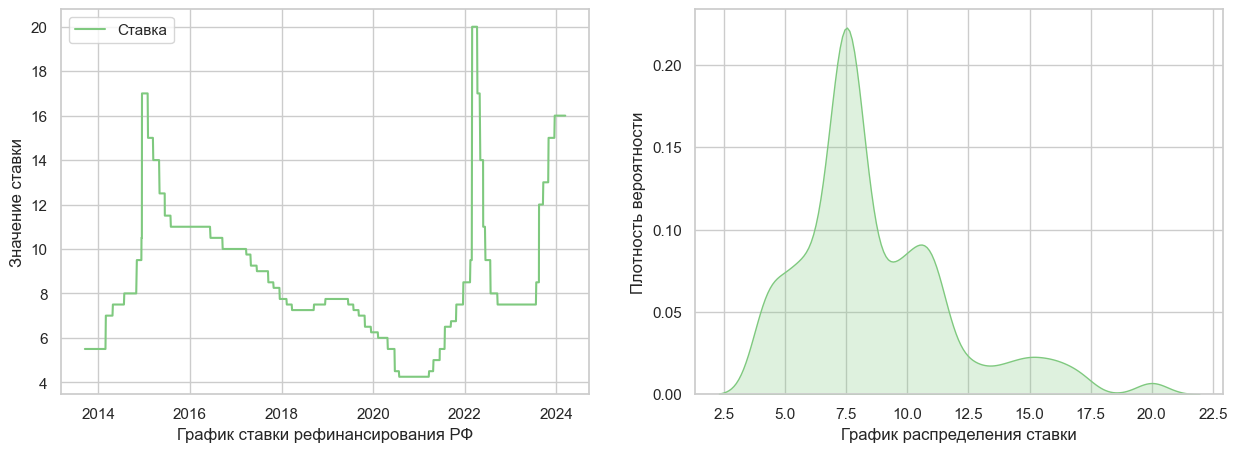

In [36]:
figure, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.set_theme(style="whitegrid", palette="Accent")

sns.lineplot(x='date', y='key_rate', data=df, label='Ставка', ax=axes[0])
axes[0].set_xlabel('График ставки рефинансирования РФ')
axes[0].set_ylabel('Значение ставки')
axes[0].legend(loc='best')
axes[0].grid(True)

sns.kdeplot(x=df['key_rate'], ax=axes[1], fill=True)
axes[1].grid(True)
axes[1].set_xlabel('График распределения ставки')
axes[1].set_ylabel('Плотность вероятности')
plt.show()

In [37]:
def create_features(data, col_datetime):
    """Создание сезонов"""

    data = data.copy()
    data['weekday'] = data[col_datetime].dt.day_name().astype(cat_day)
    data['month'] = data[col_datetime].dt.month_name().astype(cat_month)
    data['year'] = data[col_datetime].dt.year
    data['quarter'] = data['date'].dt.quarter
    data['date_offset'] = (data[col_datetime].dt.month * 100 + data.date.dt.day - 320) % 1300
    data['season'] = data[col_datetime].dt.month.map({1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'})
    
    return data

cat_day = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered= True)
cat_month = CategoricalDtype(categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered= True)


df_features = create_features(data=df, col_datetime='date')

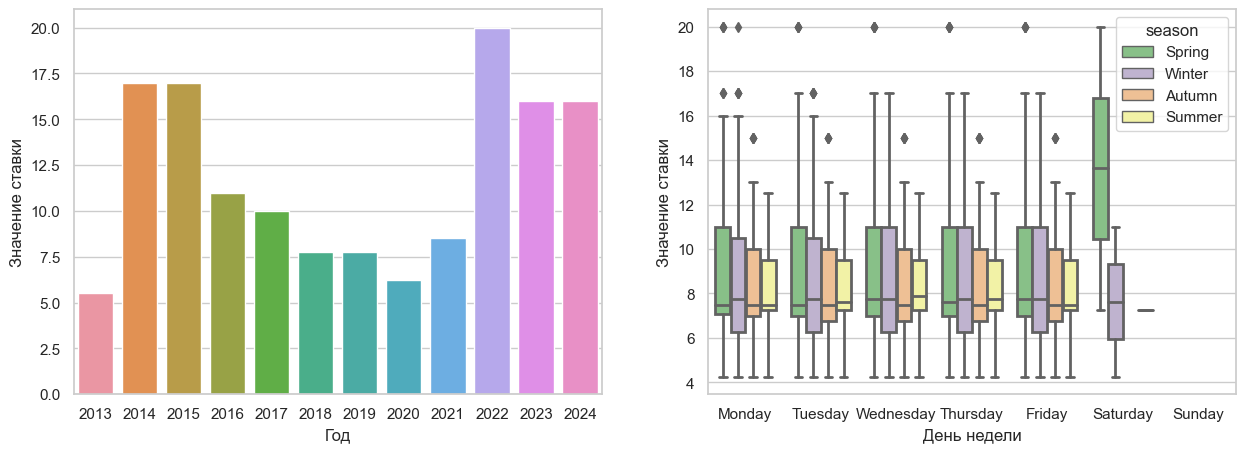

In [38]:
figure, axes = plt.subplots(1, 2, figsize=(15, 5))

year_group = pd.DataFrame(df_features.groupby('year')['key_rate'].max()).reset_index().sort_values('key_rate')

sns.barplot(data=year_group, x='year', y='key_rate', ax=axes[0])
axes[0].set_xlabel('Год')
axes[0].set_ylabel('Значение ставки')

sns.boxplot(data=df_features, x='weekday', y='key_rate', hue='season', ax=axes[1], linewidth=2)
axes[1].set_xlabel('День недели')
axes[1].set_ylabel('Значение ставки')

plt.show()



In [39]:
drop_trash = df_features[(df_features.weekday == 'Saturday') | (df_features.weekday == 'Sunday')].index
df = df[~df.index.isin(drop_trash)]
df = df.reset_index(drop=True)

In [40]:
# перенаименование названия колонок для Prophet
df.columns = ['ds', 'y']
# вычисляем 10% от датасета для его будущего разделения
fix_percent = int(df.shape[0]*0.1)


In [41]:

df = df.sort_values('ds')
df = df.reset_index(drop=True)

In [42]:
#разделение на train, test
df_train = df[:-fix_percent]
df_test = df[-fix_percent:]

print(df_train.shape)
print(df_test.shape)
print(df.shape)


(2351, 2)
(261, 2)
(2612, 2)


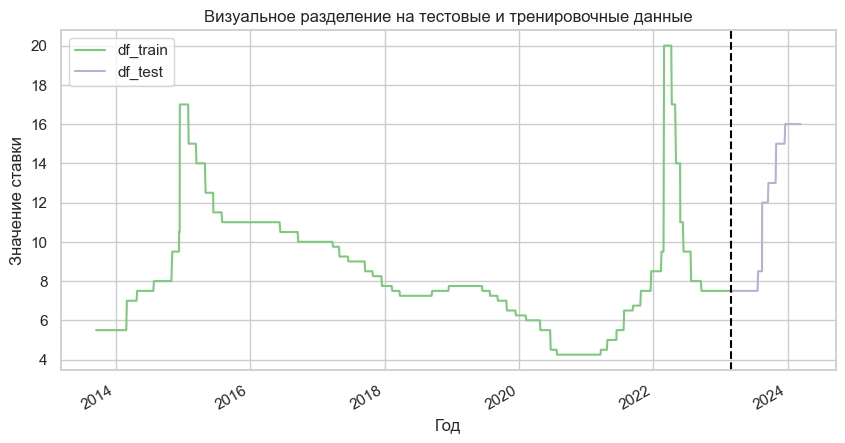

In [43]:
#нарисуем график с разделением train, test
fig, ax = plt.subplots(figsize = (10, 5))

df_train.set_index('ds').plot(ax=ax, label= 'train', title='Визуальное разделение на тестовые и тренировочные данные')
df_test.set_index('ds').plot(ax=ax, label='test')
ax.axvline(df_train['ds'][-1:].values, ls='--', color='black')
ax.legend(['df_train', 'df_test'])
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

In [45]:
%%time

# Baseline Prophet
bs_prophet = Prophet()
bs_prophet.fit(df)

01:37:27 - cmdstanpy - INFO - Chain [1] start processing
01:37:27 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 281 ms
Wall time: 1.02 s


Для тюнинга модели Prophet в Python, можно улучшить прогнозы с помощью различных методов. Во-первых, для установки библиотеки Prophet в Python, используйте команду: pip install fbprophet
1. Prophet предоставляет API для Python и R, но для данного случая используется Python
3.Один из способов улучшения прогнозов с помощью Prophet - это использование других моделей вместе с ним. Например, можно обучить несколько Prophet моделей и использовать их результаты как признаки для мета-модели, что аналогично стекингу
3. Этот подход позволяет улучшить качество предсказаний без изменения данных.
Кроме того, можно использовать LightGBM вместе с Prophet для улучшения прогнозов. Это позволяет дополнительно настраивать прогнозы и повышать точность модели
3.Таким образом, для тюнинга модели Prophet в Python, рекомендуется установить библиотеку, использовать несколько моделей Prophet вместе или комбинировать Prophet с другими методами, такими как LightGBM, для улучшения прогнозов временных рядов.

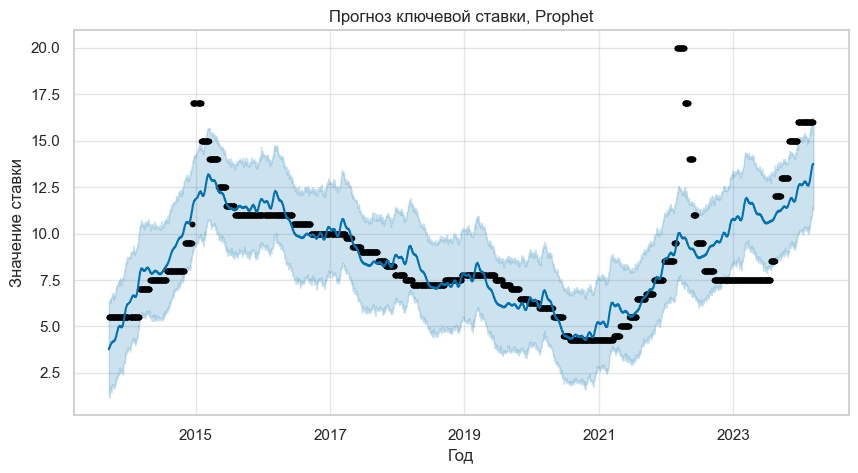

In [46]:
fix, ax = plt.subplots(figsize= (10, 5))

predict = bs_prophet.predict(df)
fig = bs_prophet.plot(predict, ax=ax)
ax.set_title('Прогноз ключевой ставки, Prophet')
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()


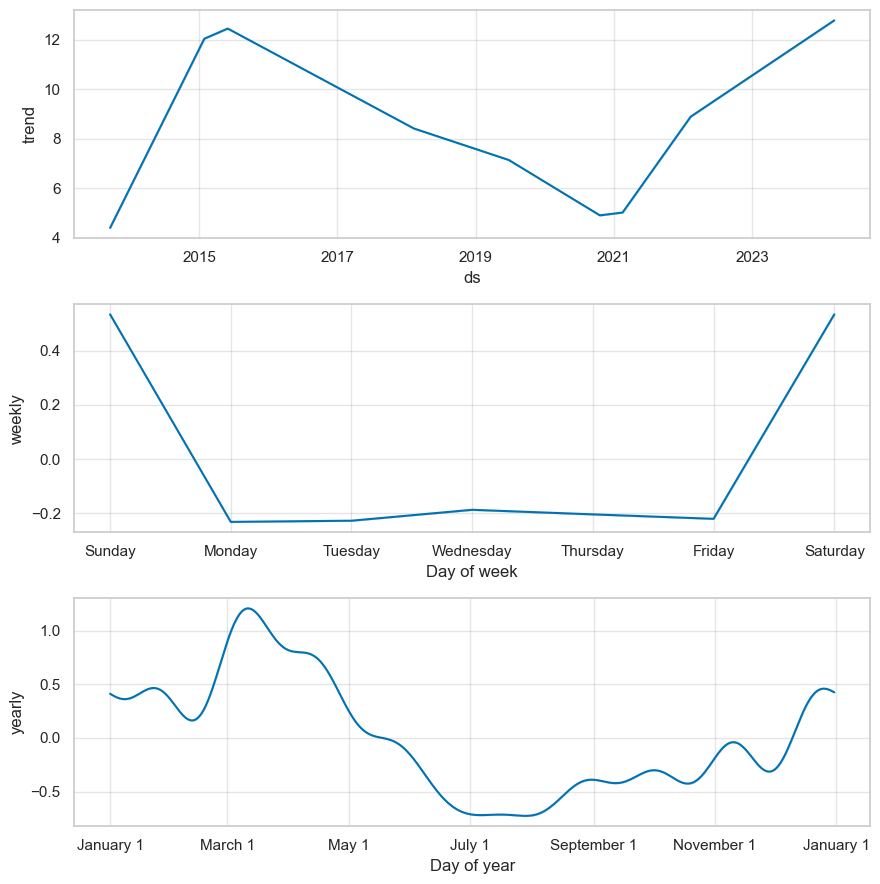

In [47]:
fig = bs_prophet.plot_components(predict)
plt.show()

In [49]:
from prophet.make_holidays import make_holidays_df

nsw_holidays = make_holidays_df(
    year_list=[2019 + i for i in range(10)], country='RU')
nsw_holidays.head(n=10)

,ds,holiday
0,2019-01-01,New Year Holidays
1,2019-01-02,New Year Holidays
2,2019-01-03,New Year Holidays
3,2019-01-04,New Year Holidays
4,2019-01-05,New Year Holidays
5,2019-01-06,New Year Holidays
6,2019-01-08,New Year Holidays
7,2019-01-07,Christmas Day
8,2019-02-23,Fatherland Defender's Day
9,2019-03-08,International Women's Day
